# **Reinforcement Learning Method to Optimise Traffic Light Signal Control in Typical Urban Four-Way Intersection Using SUMO Traffic Simulator**

By team DREAM.

Contributors:
- Alex Wang (z5420393)
- Dhwanish Kshatryia (z5421168)
- Evan Xiong (z5421149)
- Michael Wang (z5421148)
- Rohan Agarwal (z5423480)

In [ ]:
import os
import sys
import random
from collections import deque
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import traci
import matplotlib.pyplot as plt
from itertools import product
import pandas as pd
import itertools
import collections
import matplotlib.pyplot as plt
import seaborn as sns


## **Introduction, Motivation and/or Problem Statement**

### **Problem Statement**

Inefficient traffic light control results in increased levels of congestion. Higher levels of congestion will have detrimental impacts on society, as drivers will have more idle time which leads to the following issues:
- Poorer quality of life/Driver frustration due to being stuck in traffic
- Longer travel time due to delays in traffic
- Reduced economic productivity
- Higher levels of greenhouse emissions as vehicles will be on the road longer

Currently, Sydney adopts mostly fixed timers to control traffic lights. A traffic light control system based on fixed timers has caused delays in traffic such that it takes on average 15 more minutes to reach the same destination. Additionally, there's 6.1 billion in lost productivity annually. This issue is becoming increasingly relevant as Sydney's population is projected to rise and be 6.4 million by 2036. This means there will be more drivers on the road, which will contribute to higher levels of congestion.

Our objective is to optimise Sydney's traffic flow and reduce congestion by developing a traffic light control system that is efficient under most scenarios.

**History of Problem**

To better understand this problem, it is useful to examine its history and previous research contributions. Over the past two decades, numerous approaches have been proposed to optimise traffic flow. Early models primarily relied on Q-learning; however, the state space in these implementations was often poorly defined. For example, the queue length of an incoming lane was typically classified into broad categories such as “low,” “medium,” or “high,” leading to oversimplified assumptions and reduced accuracy in the resulting models.

A significant breakthrough occurred in 2016, when researchers demonstrated that Q-values could be approximated using neural networks. This innovation allowed models to handle large and complex state–action spaces that traditional Q-tables could not accommodate. Following this advancement, some researchers explored the use of recurrent neural networks (RNNs) for traffic optimisation, leveraging their ability to model sequential data and capture temporal dependencies in traffic patterns.

### **Purpose**

To address this issue, we considered a reinforcement learning approach. As opposed to other approaches, reinforcement learning is able to handle sequential data through associating actions and delayed rewards. Optimising traffic flow has its applications in other fields, namely factoring queuing systems and warehouse automation.

## **RL Simulation Tool**

### **SUMO Config**

In [ ]:
# Build the SUMO command-line arguments for our RL simulation
def sumo_config(traffic_pattern="P1", seed=23423):
    sumo_config = [
        "sumo",
        "-c", f"SUMO_networks/{traffic_pattern}/junction.sumocfg",  # traffic pattern to simulate
        "--step-length", "0.05",                                    # simulation step granularity of 0.05 seconds
        "--delay", "0",                                             # simulation delay (max speed)
        "--lateral-resolution", "0.1",                              # Vehicle movement granularity
        "--waiting-time-memory", "1800",                            # Memory in seconds 
        "--seed", f"{seed}",                                        # Simulation seed
        "--start",                              
        "--no-warnings",
        "--no-step-log",
    ]
    return sumo_config

# Start sumo environment
if "SUMO_HOME" in os.environ:
    tools = os.path.join(os.environ["SUMO_HOME"], "tools")
    sys.path.append(tools)
else:
    sys.exit("Declare SUMO_HOME env variable")

if not traci.isLoaded():
    traci.start(sumo_config())


### **Helpers - Navigating Sumo Env:**

Below are some helper functions used for reserring and changing traffic patterns within the environment. 

In [ ]:
# List of traffic patterns (more info in data analysis section)
traffic_patterns = itertools.cycle(["P1", "P2", "P3", "P4"])

# Creates a new sumo simulation on a random seed for a specified traffic pattern
def reset_env(pattern="P1"):
    if traci.isLoaded():
        traci.close()
    traci.start(sumo_config(pattern, random.randint(1, 99999)))

# Cycles through traffic patterns when called — used during RL agent training
def change_env():
    pattern = next(traffic_patterns)
    if traci.isLoaded():
        traci.close()
    traci.start(sumo_config(pattern, random.randint(1, 99999)))


### **Data Source:**

In our project, SUMO (Simulation of Urban Mobility) is the environment in which the reinforcement learning agent interacts with to learn from realistic traffic conditions. SUMO is an open-source, microscopic traffic simulation framework which simulates a realistic urban intersection and generates traffic flow which enables us to model the complex, non-linear dynamics of an urban intersection. It is designed to model the movement of individual vehicles, pedestrians, and public transport in a transportation network. SUMO is widely used in traffic research, intelligent transportation systems (ITS) development, and reinforcement learning (RL) for traffic control. The integration with reinforcement learning is made possible through TraCI (Traffic Control Interface), which allows our agent to query the simulation for state information, modify traffic light phases, and receive updated traffic conditions in real time.

The core features of SUMO include:
1. Microscopic Simulation: SUMO models each vehicle individually, tracking position, speed, and behavior.
2. Custom Traffic Scenarios: SUMO networks can be created from real-world maps (e.g., OpenStreetMap) or synthetic networks.
3. Flexibility: SUMO can be used with external tools via TraCI (Traffic Control Interface) for online control and RL integration.

### **How we used SUMO for our RL Task:**

The RL task we define is adaptive traffic signal control at a four-way intersection with two lanes in each direction. Unlike fixed-time control, our approach aims to dynamically adjust traffic signal phases based on real-time traffic conditions to reduce congestion and improve flow.

For our project, we used to SUMO to:

- Create a synthetic four-way intersection with two lanes per approach and dedicated turning lanes.
- Define 4 distinct traffic patterns explained further in **RL Data Design**
- Generate vehicle arrival data using SUMO's random trip generation, with parameters set to achieve the desired flow profiles. The randomness in arrival times (which follow a poisson distribution) ensures each episode differs slightly, preventing overfitting to a single deterministic pattern.

# **RL Task**

In [ ]:
# Global Variables for Simulation
action_space_size = 8                               # Action Space Size (8 possible actions)
TRAFFIC_LIGHT_ID = "traffic_light"                  # Traffic light ID (for interfacing with SUMO)
DELTA_PHASE_DURATION = 6                            # Length of traffic light phase extension
YELLOW_PHASE_DURATION = 4                           # Yellow light phase length
lane_detectors = [f'q{i+1}' for i in range(8)]      # Lane detector IDs (for interfacing with SUMO)
current_phase = 2                                   # Id of traffic light phase that the simulation is initialised with

# Returns the queue length for each lane detector
def get_queue_length():
    return torch.tensor([
        traci.lanearea.getLastStepHaltingNumber(d) for d in lane_detectors
    ], dtype=torch.float)

# Simulates the traffic environment for the given number of seconds (20 steps per second)
def simulate_time(seconds=1):
    for _ in range(20 * seconds):
        traci.simulationStep()


For our project, the reinforcement learning task is **adaptive traffic signal control** at a single urban intersection. As mentioned previously, this environment was simulated using SUMO and is made up of a four way intersection with two lanes in each direction. Each lane is either a through-lane movement or a turning movement, and traffic flows are controlled using predefined traffic light phase configurations. The intersection and possible lane directions are visually depicted below:

<p align="center">
  <img src="image_7.png" alt="SUMO Intersection" width="50%"/>
</p>

In our configured SUMO environment, vehicle arrival rates were modelled using a Poisson Distribution to introduce some variability in traffic demand. By having a stochastic arrival process, we ensured that no two simulation runs were identical, regardless of which traffic patterns were used (e.g. if both used pattern P2, the simulation run would not be the same due to different arrival rates).

In order to train and evaluate our RL Agent, we used four distinct traffic patterns based on scenarios proposed in the Guo, M.(2019) paper. The four traffic patterns (P1–P4) represent a unique combination of lane-specific arrival rates and temporal demand patterns. This setup ensures the agent experiences both stationary and non-stationary traffic conditions during training and evaluation. The configurations of the traffic patterns are shown and described below:

<p align="center">
  <img src="image_5.png" alt="Traffic Pattern Configurations" width="50%"/>
</p>

- **Pattern P1 - Major/Minor Road Traffic:** One road carries significantly higher traffic volume than the other, representing a major road intersecting with a side street. This teaches our RL agent to prioritise heavily used approaches without neglecting low-volume lanes.
- **Pattern P2 - Through/Left-Turn Lane Traffic:** Traffic demand is unevenly distributed between straight-through and left-turning lanes. This teaches our RL agent to recognise and adapt to lane-specific congestion rather than treating all lanes equally.
- **Pattern P3 - Tidal/Rush Hour Traffic:** Traffic is directionally biased, with heavy flow in one direction for part of the simulation, then reversing later, simulating rush-hour effects. This teaches our RL agent to adapt its strategy over time within a single episode as dominant flows change direction.
- **Pattern P4 - Varying Traffic Demand:** Traffic demand fluctuates unpredictably during the episode. This tests the agent’s ability to generalise to unseen, dynamically changing conditions and react without prior pattern knowledge.

To ensure our RL Agent's generalisation ability, we exposed our RL Agent to 3 traffic patterns, P1, P2 and P3 during training. Unlike the paper by Guo, M.(2019) which exposes a different agent to each different pattern, we chose to expose our single agent to all 3 patterns (to show the agent varied but structured conditions). Pattern P4 by contrast is reserved as our unseen test set. As such, our setup ensures and assesses the agent’s ability to generalise to unfamiliar and dynamic traffic conditions.

The agent’s objective is to learn a policy that selects optimal traffic light phases to minimise total queue length across all lanes while adapting to the unique characteristics of each pattern.

## **Methods**

### **Prior Work**
Our work builds on:
- Guo et al. (2019): A Reinforcement Learning Approach for Intelligent Traffic Signal Control at Urban Intersections.
- Mnih et al. (2015): Human-level control through deep reinforcement learning.

### **Simulation Environment Setup**

Recall, that our environment is a four-way intersection with 2 lanes per approach (through and turning). We used a simulation step length of 0.05 seconds to allow the agent highly granular control over the traffic. Further, vehicle arrival times were generated using a poisson process, introducing a random stochastic element to prevent overfitting to specific patterns. Following Guo et al, the 4 traffic profiles (P1 to P4) were developed as described in the sections above. 

#### **Reward Function**

After taking an action $a_t$ at time step $t$, the agent receives a reward $r_t(a_t)$ defined as the **negative total queue length** in the intersection:

$$
r_t(a_t) = - \sum_{i=1}^{8} QL_i(t) = -\, QL_(t)
$$

Where:
- $QL_i(t)$ is the queue length (number of vehicles waiting at a red light) in lane $i$ at time $t$.
- $QL_(t) = \sum_{i=1}^8 QL_i(t)$ is the total queue length across all 8 lanes at time $t$.

---
#### **Justification & Comparison to Guo et al (2019)**

This reward function was derived from the one utilised Guo et al (2019). Specifically, they define:

$$
r_t^{\text{Guo}}(a_t) = QL_(t-1) - QL_(t)
$$

At time $t$, $QL_(t-1)$ is already determined. Therefore, maximising $r_t^{\text{Guo}}$ is equivalent to **minimising $QL_(t)$**. This means that both reward functions select the same action - the one minimizing the queue length $QL_(t)$. The rationale behind these reward functions is for the agent to be rewarded for **reducing congestion** within the intersection. 

Over the sum of an episode, 

$$
\sum_{t=1}^{T} r_t^{\text{Guo}}
= \sum_{t=1}^{T} \left[ QL_(t-1) - QL_(t) \right]
= \dots
= QL_(0) - QL_(T)
$$

This means that the total reward over an episode is always the **total reduction in queue length** under the formulation by Guo et al. This fails to consider intermediate congestion within the environment. However, our reward function is able to capture this, providing denser information when comparing policies. 

$$
\sum_{t=0}^{T} r_t^{\text{DREAM}}
= - \sum_{t=0}^{T} QL_(t)
$$
---

#### **Metric Tracking**
During training, the queue length of each lane was tracked per time-interval. Simultaneously, the waiting time of each vehicle within the environment was also tracked. This was done by including the following code within the training loop. 

```python
for each episode:
    for each step:
        # Update vehicle wait time metric
        for v_id in traci.vehicle.getIDList():
            wait_time = traci.vehicle.getAccumulatedWaitingTime(v_id)
            if v_id not in vehicle_wait_tracker:
                vehicle_wait_tracker[v_id] = wait_time
            elif wait_time > vehicle_wait_tracker[v_id]:
                vehicle_wait_tracker[v_id] = wait_time

        # Update queue length metric
        for i in range(len(curr_queue)):
            queue_length_tracker[i] = queue_length_tracker.get(i, 0) + curr_queue[i]
```

These metrics were used to evaluate the performance of each of our models. The following section will discuss these models. 

---

### **Baseline Model: Mimicing Traffic Control NSW**
#### **Motivation**
The baseline model is a **non-adaptive**, fixed-time traffic schedule. It was designed to mimic a simplified version NSW traffic control rules. This is **not a learning model**, but acts as a reference point to evaluate the performance improvements of the reinforcement learning agents.

#### **Design**
- Phase structure: 4 distinct traffic signal phases, each corresponding to a set of non-conflicting traffic movements. For each phase, there is a 
    - **Green light stage** with a 6 second duration, followed by a,
    - **Yellow light stage** with a 4 second duration. This is then followed by a,
    - **Mandatory phase transition**.  
- Sequence: Phases are cycled through in a fixed, predetermined order regardless of traffic conditions. These phases and their cycle is characterised by the diagram below. 

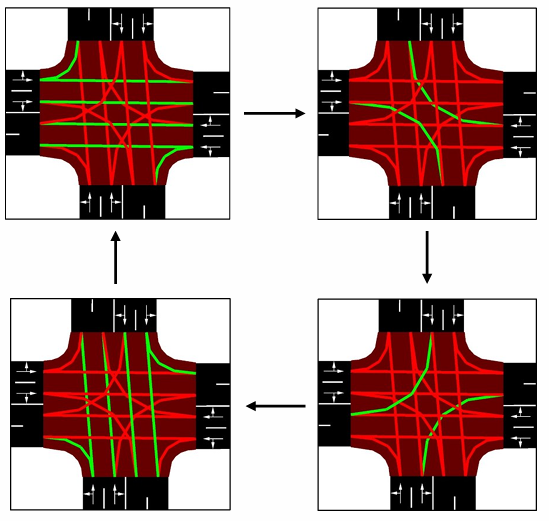

To clarify, each sub-image showcases a "phase" in which lanes are permitted to allow traffic flow. The arrows showcase the direction of phase transition. Note:
- Green lines represent lanes with green or yellow lights. Traffic is flowing in these lanes.
- Red lines represent lanes with red rights

#### **Assumptions**
- No skipping of phases, even if lanes are empty. This does not necessarily reflect NSW Traffic Control, which will skip a particular phase if there are no vehicles queued
- Vehicle arrivals follow the same Poisson process as in the RL experiments, ensuring a fair comparison.

## **Q-Learning Framework**
Define:
- $\mathcal{S}$ as the set of possible states.
- $\mathcal{A}$ as the set of possible actions (signal phases).
- $R(s,a,s')$ as the immediate reward received when transitioning from state $\mathcal{s}$ to $\mathcal{s'}$ using action $\mathcal{a}$.
- $\gamma \in [0,1)$ as discount factor for future actions. 

---

#### **Value Functions and Optimality**

For a policy $\pi(a \mid s)$, we have a state-value function:
$$
V^\pi(s) = \mathbb{E}_\pi \left[ \sum_{t=0}^\infty \gamma^t r_t \,\middle|\, s_0 = s \right]
$$

And an action-value function:
$$
Q^\pi(s,a) = \mathbb{E}_\pi \left[ \sum_{t=0}^\infty \gamma^t r_t \,\middle|\, s_0 = s, a_0 = a \right]
$$

The optimal Q-function satisfies the Bellman equation:
$$
Q(s,a) = \mathbb{E} \left[ r + \gamma \max_{a'} Q^*(s',a') \,\middle|\, s,a \right]
$$

---

#### **Tabular Q-Learning**

In the tabular Q-learning, updates are made using:

$$
Q_{t+1}(s_t,a_t) \leftarrow Q_t(s_t,a_t) + \alpha \left[ r_t + \gamma \max_{a'} Q_t(s_{t+1}, a') - Q_t(s_t,a_t) \right]
$$

Where:
- $\alpha$ = learning rate
- $\gamma$ = discount factor
- $r_t$ = reward at time $t$

We adopt an $\varepsilon$-greedy policy. This means that the agent chooses a random action with probability $\varepsilon$ to "explore" actions that it has not learnt (and thus may not know the optimality of). $\varepsilon$ is decayed over time (to a minimum value) to ensure there is less focus on "exploration" in later stages. 

---
#### **Deep Q-Learning**

When the state space $|\mathcal{S}|$ is large, we approximate it using a deep Q-network (DQN)

$$
Q(s,a;\theta) \approx Q(s,a)
$$

The DQN target for a transition $(s,a,r,s')$ is:

$$
y = r + \gamma \max_{a'} Q(s',a';\theta^-)
$$

Using this, we minimising the MSE, 

$$
\mathcal{L}(\theta) = \left( y - Q(s,a;\theta) \right)^2
$$

Where:
- $\theta$ are the parameters DQN
- $\theta^-$ are the parameters of the target network. This has a lower update freq.

---

#### **Stabilisation Techniques**
1. Experience Replay: Store transitions $(s,a,r,s')$ in a buffer and sample i.i.d. mini batches to break correlation.
2. Target Network: Maintain $\theta^-$ as a delayed copy of $\theta$; update every $n$ steps.

---

#### **Definition of Actions**
Eight potential actions were defined according which align with those defined by Guo et al (2019). These are distinct non-conflicting combinations of traffic movement. 

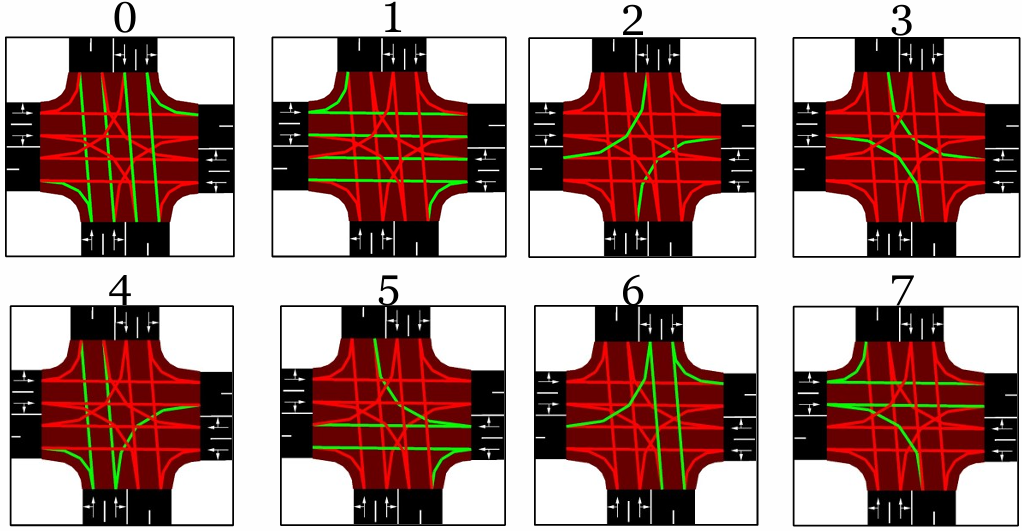

Once again:
- Green lines represent lanes with green or yellow lights. Traffic is flowing in these lanes.
- Red lines represent lanes with red rights

In [ ]:
# Function used during training to choose the next action
# A random action is chosen with probability epsilon.
# Otherwise, action with greatest Q value predicted by DQN is chosen.
def choose_action(state, epsilon, policy_net):
    if random.random() < epsilon:
        return random.randint(0, action_space_size - 1)
    else:
        return torch.argmax(policy_net(state.unsqueeze(0))).item()


In [ ]:
# Function to train the DQN using a target network and experience replay
def optimise_model(policy_net, target_net, memory, optimizer, batch_size, gamma):
    # If memory not large enough, then skip
    if len(memory) < batch_size:
        return
    
    # select a random batch from memory 
    batch = random.sample(memory, batch_size)
    states = torch.stack([x[0] for x in batch])
    actions = torch.tensor([x[1] for x in batch]).unsqueeze(1)
    rewards = torch.tensor([x[2] for x in batch], dtype=torch.float)
    next_states = torch.stack([x[3] for x in batch])
    dones = torch.tensor([x[4] for x in batch], dtype=torch.float)

    # Get predicted Q-values for the actions previously taken
    q_vals = policy_net(states).gather(1, actions).squeeze()

    with torch.no_grad():
        # Get max predicted Q-value for next state from target network
        max_next_q_vals = target_net(next_states).max(1)[0]
        # Compute target Q-values using Bellman equation
        target_vals = rewards + gamma * max_next_q_vals * (1 - dones)
    
    # Compute loss between predicted Q-values and target Q-values
    loss = nn.MSELoss()(q_vals, target_vals)
    
    # Backpropagation step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


## **Architecture 1: Dense DQN**

#### **State Representation**
The state $s_t$ at time $t$ was defined as:
$$
s_t = \left[ QL_1(t), QL_2(t), \dots, QL_8(t) \right]'
$$

Where $QL_i(t)$ is the queue length (number of vehicles waiting) in lane $i$ at time $t$. This is an 8D vector that captures the level of congestion within the environment.

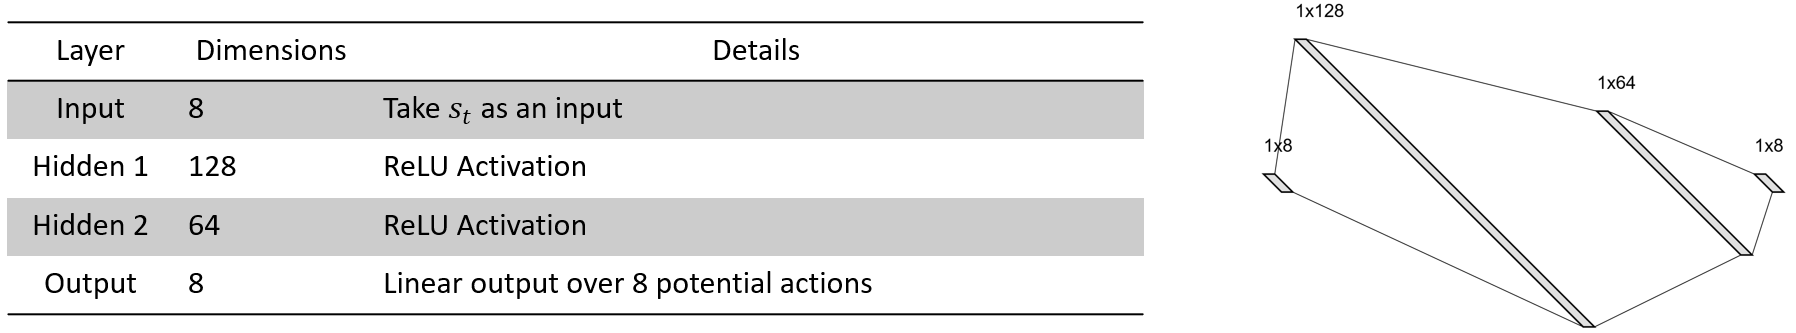


In [8]:
# The current state is defined as queue length for each lane detector
def get_current_state():
    return get_queue_length()


**Loss function:**
$$
\mathcal{L}(\theta) =  \sum_ {all (s,a,r,s')} \left[ y - Q(s,a;\theta) \right]^2
$$

Where the target $y = r + \gamma \max_{a'} Q(s',a';\theta^-)$

**Other Details:**
- Stabilisation using experience replay buffer and periodic updates to the target network.
- ADAM optimiser

In [7]:
class DQN_FC(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(state_dim, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, action_dim)
        )

    def forward(self, x):
        return self.main(x)


In [ ]:
# Simulates an action. 

# Note that (2 * action) is used due to how traffic light phases were set in SUMO. Even IDs (2n) corresponded to green lights while the corresponding yellow lights were (2n + 1).
def step(action):
    # variable to keep track of current traffic light phase
    global current_phase

    # If same action chosen, extend phase.
    if 2 * action == current_phase:
        traci.trafficlight.setPhase(TRAFFIC_LIGHT_ID, 2 * action)
        simulate_time(DELTA_PHASE_DURATION)
    # Else, trigger mandatory yellow light and then change to new phase
    else:
        traci.trafficlight.setPhase(TRAFFIC_LIGHT_ID, current_phase + 1)
        simulate_time(YELLOW_PHASE_DURATION)
        current_phase = 2 * action
        traci.trafficlight.setPhase(TRAFFIC_LIGHT_ID, 2 * action)
        simulate_time(DELTA_PHASE_DURATION)
    
    # Get new state, reward, and whether simulation is done.
    next_state = get_current_state()
    reward = -torch.sum(next_state)
    done = traci.simulation.getMinExpectedNumber() == 0
    return next_state, reward, done, next_state.clone() 


## **Architecture 2: Convolutional DQN**

#### **State Representation**
The state is defined as the last 4 consecutive $84 \times 84$ frames of vehicle coordinates, stacked along the channel dimension. Coordinates are value-encoded, with 1 for a cell occupied by a vehicle and 0 otherwise. This results in a $4 \times 84 \times 84$ **occupancy grid** which can capture both **spatial and temporal traffic dyamics**. The general idea is that using this state-space, the DQN is able to model more complex dynamics and thus make more granular decisions. 



Mathematically:
$$
s_t = \left[ G_{t-3}, G_{t-2}, G_{t-1}, G_t \right]
$$
where $G_k \in \{0,1\}^{84\times 84}$ is the occupancy grid at time $k$.

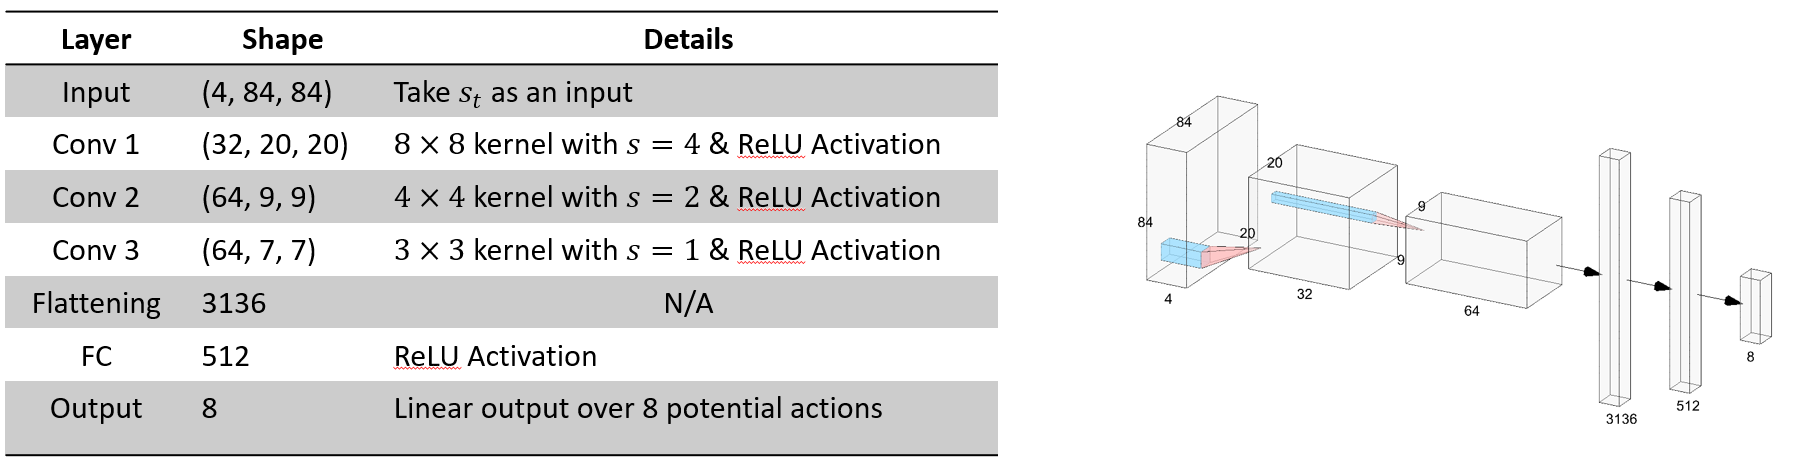


In [10]:
class DQN_CNN(nn.Module):
    def __init__(self, num_actions):
        super(DQN_CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=32, kernel_size=8, stride=4)  
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)  
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)  
        
        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.output = nn.Linear(512, num_actions)

    def forward(self, x):
        x = x / 255.0  
        x = F.relu(self.conv1(x))   
        x = F.relu(self.conv2(x))  
        x = F.relu(self.conv3(x))   
        
        x = x.view(x.size(0), -1)   
        x = F.relu(self.fc1(x))
        return self.output(x)      


In [ ]:
# Generate occupancy grid of size 84x84 representing vehicle positions in the current SUMO state
def generate_occupancy_grid(grid_size=(84, 84),
                             bounds=(-115, 100, -90, 125)):
    x_min, x_max, y_min, y_max = bounds
    x_scale = grid_size[1] / (x_max - x_min)
    y_scale = grid_size[0] / (y_max - y_min)

    grid = torch.zeros(grid_size, dtype=torch.float32)

    for v_id in traci.vehicle.getIDList():
        x, y = traci.vehicle.getPosition(v_id)

        if x_min <= x <= x_max and y_min <= y <= y_max:
            col = int((x - x_min) * x_scale)
            row = int((y - y_min) * y_scale)

            if 0 <= row < grid_size[0] and 0 <= col < grid_size[1]:
                grid[row, col] = 1.0  

    return grid


frame_buffer = deque(maxlen=4)
# Return a 4x84x84 tensor representing the last 4 seconds of traffic
def get_current_state_cnn():
    frame_buffer.clear()  # clear previous frames to maintain consistency

    for _ in range(4):
        simulate_time(1)  # simulate 1 second
        grid = generate_occupancy_grid()
        frame_buffer.append(grid.unsqueeze(0))

    state = torch.cat(list(frame_buffer), dim=0)
    return state


# Simulates an action. 

# Same as step function for first DQN model, except the amount of time simulated is reduced by 4. This is because the get_current_state_cnn simulates 4 seconds afterwards.
# The next_state representation is also now a 4x84x84 tensor.
def step_cnn(action):
    global current_phase
    if 2 * action == current_phase:
        traci.trafficlight.setPhase(TRAFFIC_LIGHT_ID, 2 * action)
        simulate_time(DELTA_PHASE_DURATION - 4)
    else:
        traci.trafficlight.setPhase(TRAFFIC_LIGHT_ID, current_phase + 1)
        simulate_time(YELLOW_PHASE_DURATION)
        current_phase = 2 * action
        traci.trafficlight.setPhase(TRAFFIC_LIGHT_ID, 2 * action)
        simulate_time(DELTA_PHASE_DURATION - 4)
    next_state = get_current_state_cnn()
    queue_length = get_queue_length()
    reward = -torch.sum(queue_length)
    done = traci.simulation.getMinExpectedNumber() == 0
    return next_state, reward, done, queue_length


## Evaluation Metrics (what we measured & why):

We chose 3 main evaluation metrics for model interpretability and to help us tune values, analyse training status and evaluate final model performance:

* Average reward (↑) as a proxy for overall flow/throughput (equivalent to negative queue length). It is measured in number of cars in queue
* Average wait time (↓) as a direct reflection of driver experience, as well as direct interpretability of model performance. It is measured in seconds.
* Maximum wait time (↓) as a check for worst-case fairness and tail risk, to see if in the process of optimising the model reward the model creates situations where the minority car is prevented from moving for a very long time. This is also measured in seconds.

Although we have defined the metrics as 'average' reward and wait time, and 'maximum' wait time, this is an 'average' and 'maximum' over all the episodes of an entire simulation process (training, evaluation, etc.). As a result, we have interim values as well - for every episode what is the reward? Here, an episode describes one singular simulation, where all vehicles go from start to finish.

## **Hyperparameter Tuning Results**

In [8]:
import pandas as pd
pd.set_option("display.width", 200)          # Increase total display width
pd.set_option("display.max_columns", None)   # Show all columns
pd.set_option("display.max_colwidth", None)  # Don't truncate cell content

In [9]:
fc = pd.read_csv('grid_search_results.csv')
display(fc)

,gamma,epsilon,epsilon_decay,min_epsilon,learning_rate,batch_size,target_update_freq,memory_size,avg_reward,avg_reward_last_N,avg_wait_last_N,max_wait_last_N,Unnamed: 12,Unnamed: 13
0,0.990,0.9,0.97,0.05,0.001,128,1800,10000,-1396.920,-1116.225,7.095134,298.20,NaN,1
1,0.990,0.9,0.97,0.05,0.001,128,1800,20000,-1360.850,-1091.625,6.914892,293.50,NaN,2
2,0.990,0.9,0.99,0.05,0.001,128,1800,10000,-1850.245,-1280.900,8.179262,299.35,NaN,3
3,0.990,0.9,0.99,0.05,0.001,128,1800,20000,-1897.980,-1266.275,8.173142,290.45,NaN,4
4,0.995,0.9,0.97,0.05,0.001,128,1800,10000,-1411.285,-1153.025,7.278935,299.40,NaN,5
5,0.995,0.9,0.97,0.05,0.001,128,1800,20000,-1414.340,-1149.275,7.277027,298.50,NaN,6
6,0.995,0.9,0.99,0.05,0.001,128,1800,10000,-1889.895,-1262.300,8.202031,292.65,NaN,7
7,0.995,0.9,0.99,0.05,0.001,128,1800,20000,-1919.050,-1265.450,8.191753,275.90,NaN,8
8,0.999,0.9,0.97,0.05,0.001,128,1800,10000,-1355.785,-1106.000,7.018259,298.45,NaN,9
9,0.999,0.9,0.97,0.05,0.001,128,1800,20000,-1346.825,-1108.300,7.048160,297.75,NaN,10


In [10]:
cnn = pd.read_csv('grid_search_results_cnn.csv')
display(cnn)

,gamma,epsilon,epsilon_decay,min_epsilon,learning_rate,batch_size,target_update_freq,memory_size,avg_reward,avg_reward_last_N,avg_wait_last_N,max_wait_last_N,Unnamed: 12
0,0.990,0.9,0.95,0.05,0.001,128,1800,10000,-1308.230,-1212.425,8.552903,299.90,1
1,0.990,0.9,0.95,0.05,0.001,128,1800,20000,-1330.860,-1297.925,9.209163,302.80,2
2,0.990,0.9,0.97,0.05,0.001,128,1800,10000,-1421.140,-1201.145,8.234695,301.60,3
3,0.990,0.9,0.97,0.05,0.001,128,1800,20000,-1407.790,-1161.775,8.014802,296.65,4
4,0.999,0.9,0.95,0.05,0.001,128,1800,10000,-1398.130,-1323.950,8.933355,299.60,5
5,0.999,0.9,0.95,0.05,0.001,128,1800,20000,-1325.470,-1124.225,7.707654,300.00,6
6,0.999,0.9,0.97,0.05,0.001,128,1800,10000,-1447.910,-1314.625,9.271751,299.65,7
7,0.999,0.9,0.97,0.05,0.001,128,1800,20000,-1424.265,-1233.925,9.122468,299.45,8


In [16]:
fc_optimal_params = {
    "gamma": 0.99,
    "epsilon": 0.9,
    "epsilon_decay": 0.95,
    "min_epsilon": 0.05,
    "learning_rate": 0.001,
    "batch_size": 128,
    "target_update_freq": 1800,
    "memory_size": 20000
}


In [17]:
cnn_optimal_params = {
    "gamma": 0.999,
    "epsilon": 0.9,
    "epsilon_decay": 0.95,
    "min_epsilon": 0.05,
    "learning_rate": 0.001,
    "batch_size": 128,
    "target_update_freq": 1800,
    "memory_size": 20000
}

In [20]:
search_ranges_for_printing = {
    "gamma": "0.99, 0.995, 0.999",
    "epsilon": "0.9 (fixed)",
    "epsilon_decay": "0.95, 0.97, 0.99",
    "min_epsilon": "0.05 (fixed)",
    "learning_rate": "0.001 (fixed)",
    "batch_size": "128 (fixed)",
    "target_update_freq": "1800 (fixed)",
    "memory_size": "10,000, 20,000"
}

In [21]:
hyperparam_data = {
    "Hyperparameter": list(search_ranges_for_printing.keys()),
    "Search Range": list(search_ranges_for_printing.values()),
    "Final Value (Dense DQN)": [fc_optimal_params[k] for k in search_ranges_for_printing.keys()],
    "Final Value (CNN DQN)": [cnn_optimal_params[k] for k in search_ranges_for_printing.keys()]
}

df_hyperparams = pd.DataFrame(hyperparam_data)

metric_data = {
    "Metric": [
        "avg_reward", "avg_reward_last_40", "avg_wait_last_40", "max_wait_last_40"
    ],
    "Optimal FC DQN": [
        -1561.801, -1330.55, "12.62 s", "601.10 s"
    ],
    "Optimal CNN DQN": [
        -1582.07, -1558.28, "14.42 s", "588.60 s"
    ]
}

df_metrics = pd.DataFrame(metric_data)

print(df_hyperparams)
print()
print(df_metrics)


       Hyperparameter        Search Range  Final Value (Dense DQN)  Final Value (CNN DQN)
0               gamma  0.99, 0.995, 0.999                    0.990                  0.999
1             epsilon         0.9 (fixed)                    0.900                  0.900
2       epsilon_decay    0.95, 0.97, 0.99                    0.950                  0.950
3         min_epsilon        0.05 (fixed)                    0.050                  0.050
4       learning_rate       0.001 (fixed)                    0.001                  0.001
5          batch_size         128 (fixed)                  128.000                128.000
6  target_update_freq        1800 (fixed)                 1800.000               1800.000
7         memory_size      10,000, 20,000                20000.000              20000.000

               Metric Optimal FC DQN Optimal CNN DQN
0          avg_reward      -1561.801        -1582.07
1  avg_reward_last_40       -1330.55        -1558.28
2    avg_wait_last_40        1

## Hyperparameter Tuning Analysis:

Due to heavily computational restrictions, we were only able to focus on tuning discount factor γ, ε-decay, replay buffer (memory size). Gamma was chosen to be one of the parameters to tune since in real life, the future is uncertain. Thus we wanted ot pick the most ideal gamma value for this intersection to balance this. Epsilon and epsilon minimum were not tuned as it was deemed not as important as epsilon decay - as an example, if epsilon starts at 1 and decay was 0.95, then epsilon would drop to 0.9 in a few episodes anyways. Intuitively, since we have so many episodes, the epsilon will reach the minimum eventually. It is just a matter of how soon it reaches it. We chose the epsilon minimum, batch size, and target network update frequency according to the reference paper (Guo Et. Al 2019), as we thought it was reasonable. 

To choose the best models, we followed generally the criterion of minimise(-(standardised_validation reward) + standardised(average wait) + standardised(max wait)).

The hyperparameter results indicate that FCDQN preferred slightly more aggressive discount, CNN benefited from slower discount. Both the other tuned values (epsilon decay and memory size) were the same across the two models. Smaller epsilon decay indicates aggressive exploration rate decay - both models achieve relatively quick convergence and commit to a strong policy. Higher memory size indicates the benefits of a larger and more diverse replay buffer.

## **Training**

In [ ]:
# Input hyperparameters, DQN model, get_current_state and step functions
def train_agent(params, model_class, get_state_fn, step_fn, episodes=200):
    # Initialise hyperparameters
    gamma = params["gamma"]
    epsilon = params["epsilon"]
    epsilon_decay = params["epsilon_decay"]
    min_epsilon = params["min_epsilon"]
    lr = params["learning_rate"]
    batch_size = params["batch_size"]
    target_update_freq = params["target_update_freq"]
    memory_size = params["memory_size"]

    # Initialise policy and target DQNs, and also memory
    policy_net = model_class()
    target_net = model_class()
    target_net.load_state_dict(policy_net.state_dict())
    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    memory = deque(maxlen=memory_size)

    # Initialise variable to store training metrics
    rewards_per_episode = []
    avg_wait_per_ep = []
    max_wait_per_ep = []
    all_avg_queue_lengths = torch.zeros(len(lane_detectors), episodes)
    steps_done = 0

    # Initialise dict variables to store pattern specific training metrics
    pattern_names = ["P1", "P2", "P3"]
    pattern_name = itertools.cycle(pattern_names)
    pattern_episode_count = collections.defaultdict(int)
    pattern_rewards = collections.defaultdict(list)
    pattern_avg_waits = collections.defaultdict(list)
    pattern_max_waits = collections.defaultdict(list)

    # Training
    for episode in range(episodes):
        # Change to next traffic pattern
        change_env()
        current_pattern = next(pattern_name)
        pattern_episode_count[current_pattern] += 1

        # Initialise values and episode metric trackers
        state = get_state_fn()
        episode_reward = 0
        done = False
        vehicle_wait_tracker = {}
        queue_length_tracker = {}
        num_steps = 0

        while not done:
            # Choose and simulate action
            action = choose_action(state, epsilon, policy_net)
            next_state, reward, done, curr_queue = step_fn(action)
            memory.append((state, action, reward, next_state, done))
            state = next_state
            episode_reward += reward

            # Update vehicle wait time metric
            for v_id in traci.vehicle.getIDList():
                wait_time = traci.vehicle.getAccumulatedWaitingTime(v_id)
                if v_id not in vehicle_wait_tracker:
                    vehicle_wait_tracker[v_id] = wait_time
                elif wait_time > vehicle_wait_tracker[v_id]:
                    vehicle_wait_tracker[v_id] = wait_time

            # Update queue length metric
            for i in range(len(curr_queue)):
                queue_length_tracker[i] = queue_length_tracker.get(i, 0) + curr_queue[i]

            # Train DQN models
            optimise_model(policy_net, target_net, memory, optimizer, batch_size, gamma)
            if steps_done % target_update_freq == 0:
                target_net.load_state_dict(policy_net.state_dict())
            steps_done += 1
            num_steps += 1

        # Process episode metrics
        for i, total_len in queue_length_tracker.items():
            all_avg_queue_lengths[i, episode] = total_len / num_steps

        vehicle_waits = list(vehicle_wait_tracker.values())
        avg_wait = sum(vehicle_waits) / len(vehicle_waits) if vehicle_waits else 0.0
        max_wait = max(vehicle_waits) if vehicle_waits else 0.0
        avg_wait_per_ep.append(avg_wait)
        max_wait_per_ep.append(max_wait)
        rewards_per_episode.append(episode_reward.item())

        # update exploration rate
        epsilon = max(min_epsilon, epsilon * epsilon_decay)

        pattern_rewards[current_pattern].append(episode_reward.item())
        pattern_avg_waits[current_pattern].append(avg_wait)
        pattern_max_waits[current_pattern].append(max_wait)

    # Metric values in the last 20% of episodes (used for hyperparameter tuning due to computational restraints)
    N = max(1, int(0.2 * episodes))  # 20% of episodes
    avg_reward_last_N = sum(rewards_per_episode[-N:]) / N
    avg_wait_last_N = sum(avg_wait_per_ep[-N:]) / N
    max_wait_last_N = max(max_wait_per_ep[-N:]) if max_wait_per_ep[-N:] else 0.0

    return {
        "avg_reward": sum(rewards_per_episode) / episodes,
        "avg_wait_per_ep": avg_wait_per_ep,
        "max_wait_per_ep": max_wait_per_ep,
        "avg_queue_lengths": all_avg_queue_lengths,
        "rewards_per_episode": rewards_per_episode,
        "avg_reward_last_N": avg_reward_last_N,
        "avg_wait_last_N": avg_wait_last_N,
        "max_wait_last_N": max_wait_last_N,
        "trained_model": policy_net,
        "pattern_rewards": pattern_rewards,
        "pattern_avg_waits": pattern_avg_waits,
        "pattern_max_waits": pattern_max_waits
    }


In [ ]:
# Train Model Architecture 1: Dense
fc_results = train_agent(
    fc_optimal_params, 
    model_class=lambda: DQN_FC(len(lane_detectors), action_space_size),
    get_state_fn=get_current_state,
    step_fn=step
)


In [ ]:
# Save model weights
policy_fc = fc_results["trained_model"]
model_path = f"policy_fc_nn.pt"
torch.save(policy_fc.state_dict(), model_path)


In [ ]:
# Train Model Architecture 2: CNN
cnn_results = train_agent(
    cnn_optimal_params,
    model_class=lambda: DQN_CNN(action_space_size),
    get_state_fn=get_current_state_cnn,
    step_fn=step_cnn
)


In [ ]:
# Save model weights
policy_cnn = cnn_results["trained_model"]
model_path = f"policy_cnn_nn.pt"
torch.save(policy_cnn.state_dict(), model_path)


# **Results**

In [ ]:
# Line plot helper function

sns.set(style="whitegrid", context="notebook", palette="deep")

def plot_line(rewards, label, ylabel, title, baselines=None):
    plt.figure(figsize=(10, 6))

    palette = sns.color_palette("deep")
    main_color = palette[0]

    plt.plot(rewards, label=label, linewidth=2.5, marker='o', markersize=4,
             alpha=0.9, color=main_color)

    if baselines is not None:
        labels = ["P1: Major/minor road", "P2: Through/left-turn lane ", "P3: Tidal traffic"]
        for i, val in enumerate(baselines):
            if val is not None:
                color = palette[i + 1] if i + 1 < len(palette) else 'gray'
                label_text = labels[i] if i < len(labels) else f"P{i+1}"
                plt.axhline(y=val, color=color, linestyle='--', linewidth=2,
                            alpha=0.8, label=label_text)

    plt.xlabel("Episode", fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(title, fontsize=14, weight='bold')

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)

    plt.legend(fontsize=11)
    plt.tight_layout()
    plt.show()


## **Baseline Results**

In [ ]:
# Simulate fixed traffic phase length system
def get_baseline_results(pattern, episodes=1):

    # Initialise metric tracking variables
    all_avg_queue_lengths = torch.zeros(len(lane_detectors), episodes)

    pattern_rewards = []
    pattern_avg_waits = []
    pattern_max_waits = []

    # Pre-specified traffic light phase order and durations
    phase_sequence = [2, 6, 4, 0]
    green_duration = DELTA_PHASE_DURATION
    yellow_duration = YELLOW_PHASE_DURATION

    for episode in range(episodes):
        reset_env(pattern)

        # Initialise episode specific metrics
        episode_reward = 0
        done = False
        vehicle_wait_tracker = {}
        queue_length_tracker = {}
        num_steps = 0

        # Set the initial traffic light phase that is active initially
        phase_index = 0

        while not done:
            green_phase = phase_sequence[phase_index]
            yellow_phase = green_phase + 1

            # Simulate green light
            traci.trafficlight.setPhase(TRAFFIC_LIGHT_ID, green_phase)
            simulate_time(green_duration)
            num_steps += 1

            # Get information from environment
            next_state = get_current_state()
            reward = -torch.sum(next_state)
            done = traci.simulation.getMinExpectedNumber() == 0
            curr_queue = next_state.clone()

            episode_reward += reward

            # Wait tracking
            for v_id in traci.vehicle.getIDList():
                wait_time = traci.vehicle.getAccumulatedWaitingTime(v_id)
                if v_id not in vehicle_wait_tracker:
                    vehicle_wait_tracker[v_id] = wait_time
                elif wait_time > vehicle_wait_tracker[v_id]:
                    vehicle_wait_tracker[v_id] = wait_time

            # Queue length tracking
            for i in range(len(curr_queue)):
                queue_length_tracker[i] = queue_length_tracker.get(i, 0) + curr_queue[i]


            # Simulate yellow light
            traci.trafficlight.setPhase(TRAFFIC_LIGHT_ID, yellow_phase)
            simulate_time(yellow_duration)

            # Update phase index based on the predetermined order
            phase_index = (phase_index + 1) % len(phase_sequence)

        # Process metrics
        for i, total_len in queue_length_tracker.items():
            all_avg_queue_lengths[i, episode] = total_len / num_steps

        vehicle_waits = list(vehicle_wait_tracker.values())
        avg_wait = sum(vehicle_waits) / len(vehicle_waits) if vehicle_waits else 0.0
        max_wait = max(vehicle_waits) if vehicle_waits else 0.0

        pattern_rewards.append(episode_reward.item())
        pattern_avg_waits.append(avg_wait)
        pattern_max_waits.append(max_wait)

    return {
        "pattern": pattern,
        "avg_reward": sum(pattern_rewards) / episodes,
        "avg_queue_lengths": all_avg_queue_lengths,
        "pattern_rewards": pattern_rewards,
        "pattern_avg_waits": pattern_avg_waits,
        "pattern_max_waits": pattern_max_waits
    }


In [86]:
baseline_results_compiled = []
for pattern in ["P1", "P2", "P3", "P4"]:
    baseline_results = get_baseline_results(pattern, episodes=100)
    rewards = baseline_results["pattern_rewards"]
    avg_waits = baseline_results["pattern_avg_waits"]
    max_waits = baseline_results["pattern_max_waits"]

    for r in rewards:
        baseline_results_compiled.append({"Pattern": pattern, "Metric": "Reward", "Value": r})
    for a in avg_waits:
        baseline_results_compiled.append({"Pattern": pattern, "Metric": "Avg Wait", "Value": a})
    for m in max_waits:
        baseline_results_compiled.append({"Pattern": pattern, "Metric": "Max Wait", "Value": m})
    print(f"\nPattern {pattern}:")
    print(f" Episodes: {len(rewards)}")
    print(f" Avg Reward: {sum(rewards) / len(rewards):.2f}")
    print(f" Avg Wait: {sum(avg_waits) / len(avg_waits):.2f}")
    print(f" Max Wait: {max(max_waits):.2f}")



Pattern P1:
 Episodes: 100
 Avg Reward: -2901.72
 Avg Wait: 26.42
 Max Wait: 219.55

Pattern P2:
 Episodes: 100
 Avg Reward: -6904.53
 Avg Wait: 60.70
 Max Wait: 471.20

Pattern P3:
 Episodes: 100
 Avg Reward: -6131.47
 Avg Wait: 47.68
 Max Wait: 379.95

Pattern P4:
 Episodes: 100
 Avg Reward: -1838.72
 Avg Wait: 20.61
 Max Wait: 139.20


## **Model 1 results**

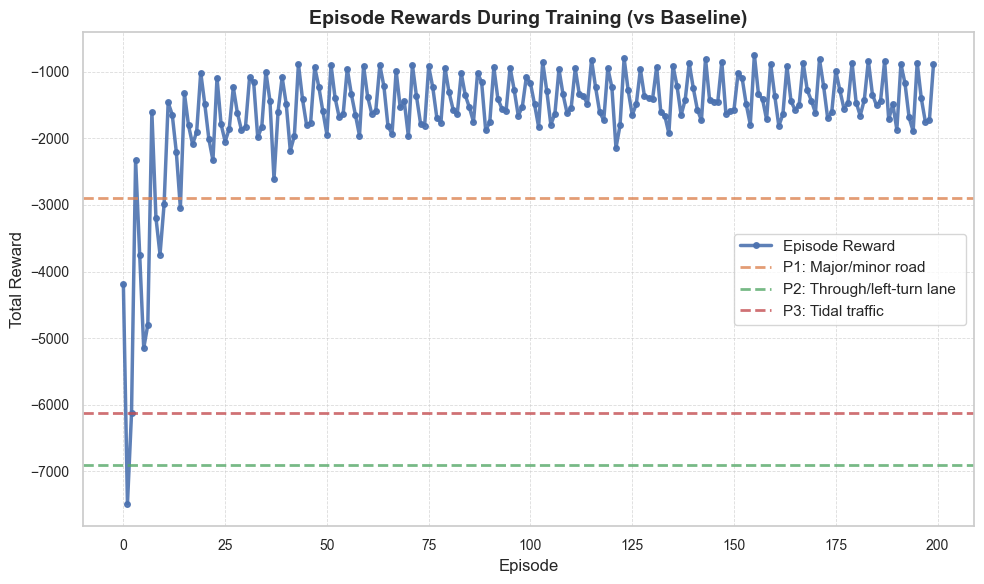

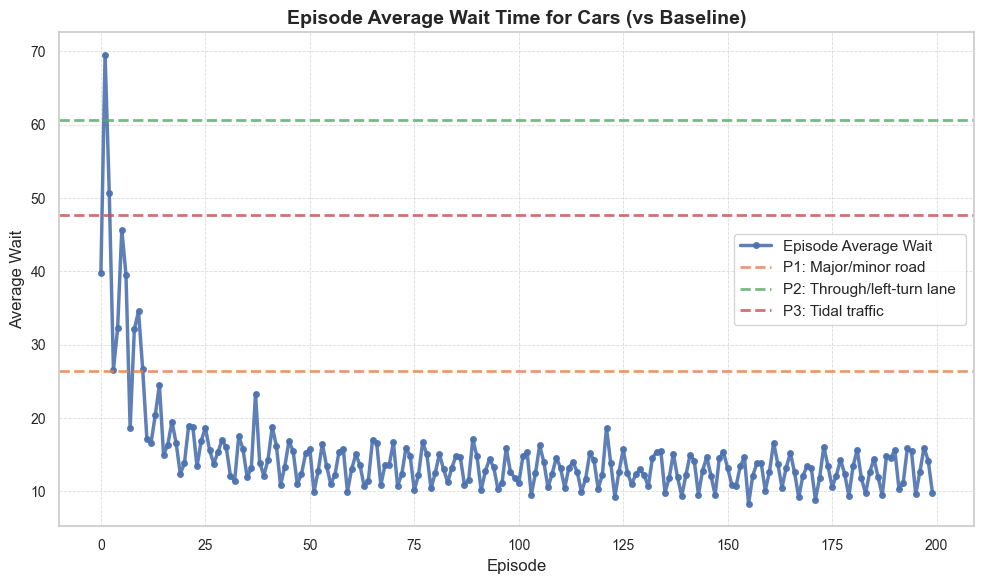

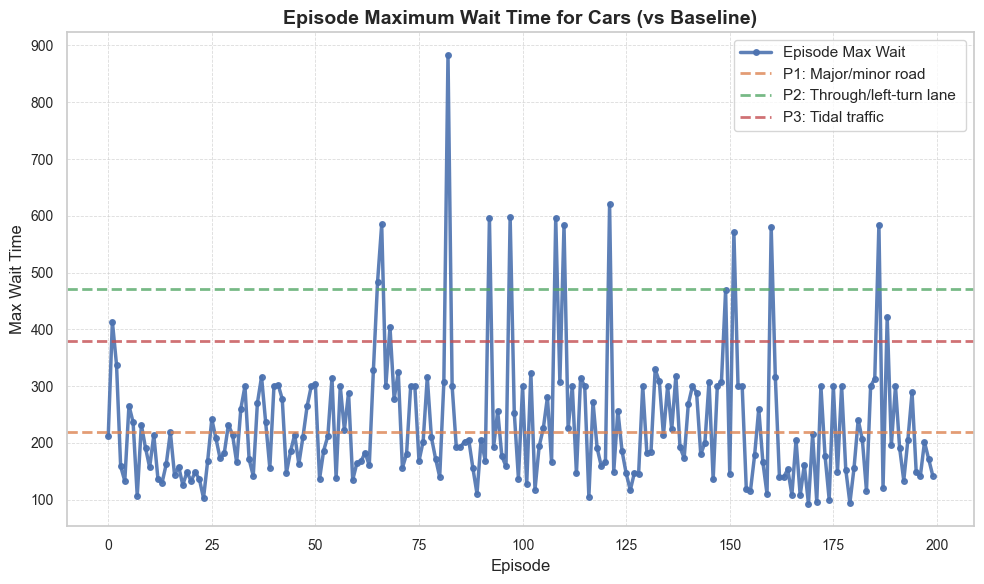

In [ ]:
# Plot metrics during each training episode
plot_line(fc_results["rewards_per_episode"], 'Episode Reward', 'Total Reward', 'Episode Rewards During Training (vs Baseline)', [-2901.72, -6904.53, -6131.47])
plot_line(fc_results["avg_wait_per_ep"], 'Episode Average Wait', 'Average Wait', 'Episode Average Wait Time for Cars (vs Baseline)', [26.42, 60.70, 47.68])
plot_line(fc_results["max_wait_per_ep"], 'Episode Max Wait', 'Max Wait Time', 'Episode Maximum Wait Time for Cars (vs Baseline)', [219.55, 471.20, 379.95])


In [22]:
print("### Fully Connected Q-Network Results ###")
for pattern in ["P1", "P2", "P3"]:
    rewards = fc_results["pattern_rewards"][pattern]
    avg_waits = fc_results["pattern_avg_waits"][pattern]
    max_waits = fc_results["pattern_max_waits"][pattern]
    print(f"\nPattern {pattern}:")
    print(f" Episodes: {len(rewards)}")
    print(f" Avg Reward: {sum(rewards) / len(rewards):.2f}")
    print(f" Avg Wait: {sum(avg_waits) / len(avg_waits):.2f}")
    print(f" Max Wait: {max(max_waits):.2f}")
print(f"\nAverage Reward (Last 40): {fc_results['avg_reward_last_N']:.2f}")
print(f"Average Wait (Last 40): {fc_results['avg_wait_last_N']:.2f}")
print(f"Max Wait (Last 40): {fc_results['max_wait_last_N']:.2f}")


### Fully Connected Q-Network Results ###

Pattern P1:
 Episodes: 67
 Avg Reward: -1554.58
 Avg Wait: 14.60
 Max Wait: 596.15

Pattern P2:
 Episodes: 67
 Avg Reward: -1596.25
 Avg Wait: 14.98
 Max Wait: 883.60

Pattern P3:
 Episodes: 66
 Avg Reward: -1609.79
 Avg Wait: 14.96
 Max Wait: 596.20

Average Reward (Last 40): -1368.40
Average Wait (Last 40): 12.77
Max Wait (Last 40): 584.65


In [ ]:
# Evaluate final trained Dense model on a input pattern
def evaluate_fc_model_on_pattern(pattern, model_path=f"policy_fc_nn.pt", episodes=1):
    # Load in trained DQN
    policy_net = DQN_FC(len(lane_detectors), action_space_size)
    policy_net.load_state_dict(torch.load(model_path))
    policy_net.eval()

    # Intialise metric trackers
    all_avg_queue_lengths = torch.zeros(len(lane_detectors), episodes)

    pattern_rewards = []
    pattern_avg_waits = []
    pattern_max_waits = []

    # Repeat for specified number of episodes to examine variance of results
    for episode in range(episodes):
        reset_env(pattern)
        state = get_current_state()

        # Episode specific metric trackers
        episode_reward = 0
        done = False
        vehicle_wait_tracker = {}
        queue_length_tracker = {}
        num_steps = 0

        while not done:
            # DQN selects the optimal action
            with torch.no_grad():
                action = policy_net(torch.tensor(state, dtype=torch.float32).unsqueeze(0)).argmax().item()
            
            # Simulate chosen action
            next_state, reward, done, curr_queue = step(action)
            state = next_state
            episode_reward += reward

            # Vehicle wait time tracking
            for v_id in traci.vehicle.getIDList():
                wait_time = traci.vehicle.getAccumulatedWaitingTime(v_id)
                if v_id not in vehicle_wait_tracker:
                    vehicle_wait_tracker[v_id] = wait_time
                elif wait_time > vehicle_wait_tracker[v_id]:
                    vehicle_wait_tracker[v_id] = wait_time

            # Queue length tracking
            for i in range(len(curr_queue)):
                queue_length_tracker[i] = queue_length_tracker.get(i, 0) + curr_queue[i]

            num_steps += 1

        # Process metrics
        for i, total_len in queue_length_tracker.items():
            all_avg_queue_lengths[i, episode] = total_len / num_steps

        vehicle_waits = list(vehicle_wait_tracker.values())
        avg_wait = sum(vehicle_waits) / len(vehicle_waits) if vehicle_waits else 0.0
        max_wait = max(vehicle_waits) if vehicle_waits else 0.0

        pattern_rewards.append(episode_reward.item())
        pattern_avg_waits.append(avg_wait)
        pattern_max_waits.append(max_wait)

    return {
        "pattern": pattern,
        "avg_reward": sum(pattern_rewards) / episodes,
        "avg_queue_lengths": all_avg_queue_lengths,
        "pattern_rewards": pattern_rewards,
        "pattern_avg_waits": pattern_avg_waits,
        "pattern_max_waits": pattern_max_waits
    }


In [49]:
fc_results_compiled = []
for pattern in ["P1", "P2", "P3", "P4"]:
    fc_results = evaluate_fc_model_on_pattern(pattern, episodes=100)
    rewards = fc_results["pattern_rewards"]
    avg_waits = fc_results["pattern_avg_waits"]
    max_waits = fc_results["pattern_max_waits"]

    for r in rewards:
        fc_results_compiled.append({"Pattern": pattern, "Metric": "Reward", "Value": r})
    for a in avg_waits:
        fc_results_compiled.append({"Pattern": pattern, "Metric": "Avg Wait", "Value": a})
    for m in max_waits:
        fc_results_compiled.append({"Pattern": pattern, "Metric": "Max Wait", "Value": m})
    print(f"\nPattern {pattern}:")
    print(f" Episodes: {len(rewards)}")
    print(f" Avg Reward: {sum(rewards) / len(rewards):.2f}")
    print(f" Avg Wait: {sum(avg_waits) / len(avg_waits):.2f}")
    print(f" Max Wait: {max(max_waits):.2f}")


C:\Users\alexw\AppData\Local\Temp\ipykernel_38348\2286365116.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy_net.load_state_dict(torch.load(model_path))
C:\Users\


Pattern P1:
 Episodes: 100
 Avg Reward: -1311.67
 Avg Wait: 12.10
 Max Wait: 922.00

Pattern P2:
 Episodes: 100
 Avg Reward: -1641.54
 Avg Wait: 15.09
 Max Wait: 1481.35

Pattern P3:
 Episodes: 100
 Avg Reward: -1655.37
 Avg Wait: 13.76
 Max Wait: 1478.40

Pattern P4:
 Episodes: 100
 Avg Reward: -919.46
 Avg Wait: 10.18
 Max Wait: 869.15


## **Model 2 results**

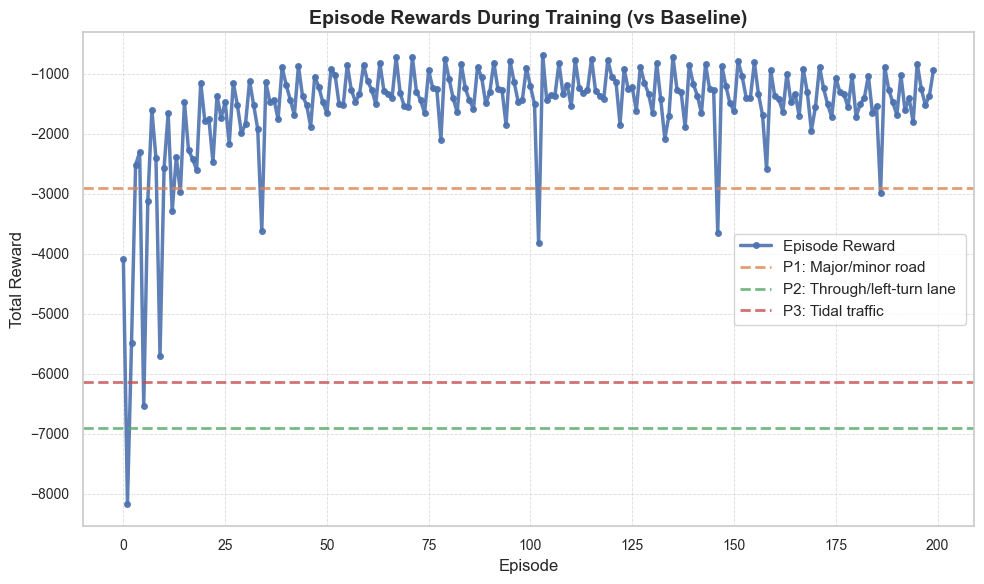

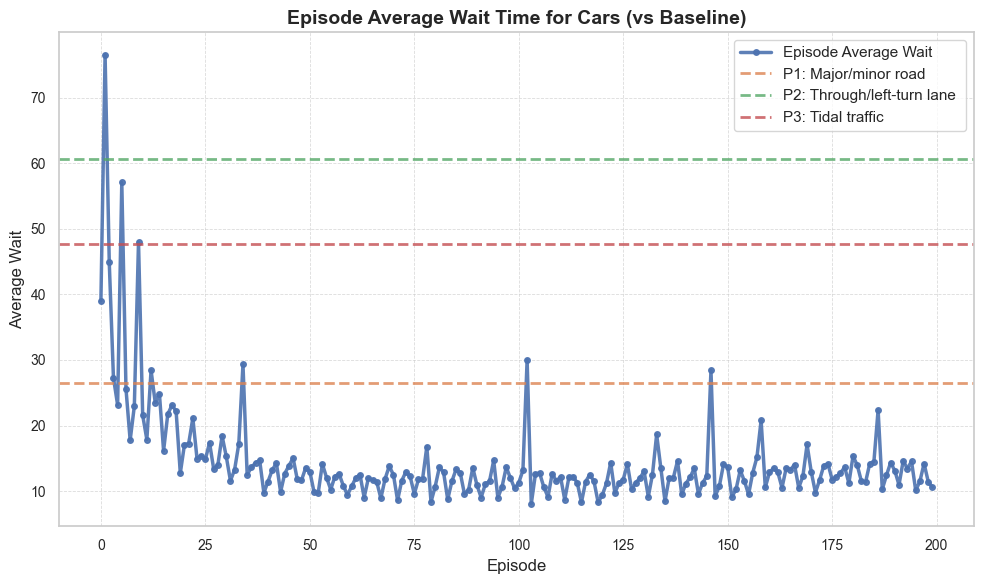

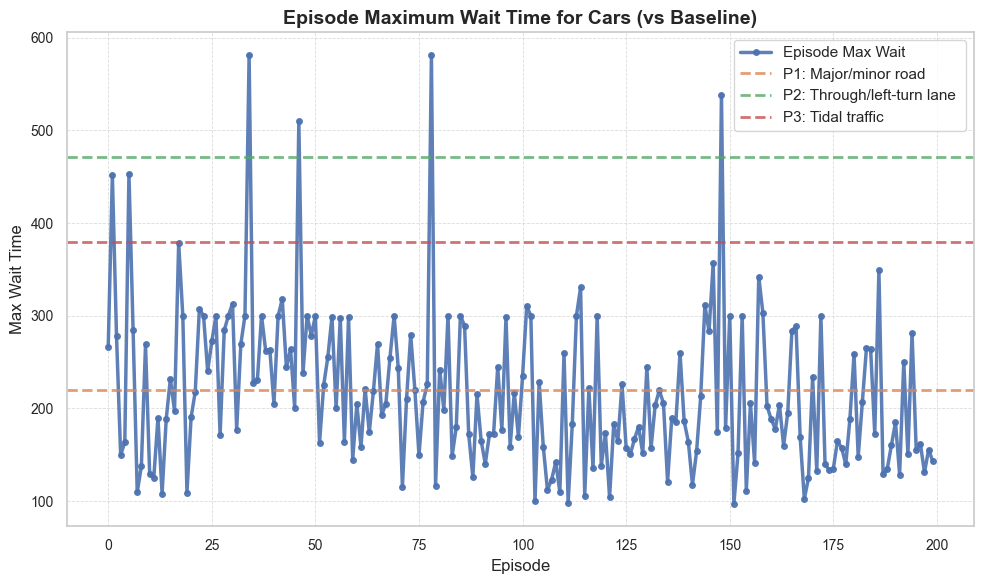

In [ ]:
# Plot metrics during each training episode
plot_line(cnn_results["rewards_per_episode"], 'Episode Reward', 'Total Reward', 'Episode Rewards During Training (vs Baseline)', [-2901.72, -6904.53, -6131.47])
plot_line(cnn_results["avg_wait_per_ep"], 'Episode Average Wait', 'Average Wait', 'Episode Average Wait Time for Cars (vs Baseline)', [26.42, 60.70, 47.68])
plot_line(cnn_results["max_wait_per_ep"], 'Episode Max Wait', 'Max Wait Time', 'Episode Maximum Wait Time for Cars (vs Baseline)', [219.55, 471.20, 379.95])


In [23]:
print("\n### CNN Q-Network Results ###")

for pattern in ["P1", "P2", "P3"]:
    rewards = cnn_results["pattern_rewards"][pattern]
    avg_waits = cnn_results["pattern_avg_waits"][pattern]
    max_waits = cnn_results["pattern_max_waits"][pattern]

    print(f"\nPattern {pattern}:")
    print(f" Episodes: {len(rewards)}")
    print(f" Avg Reward: {sum(rewards) / len(rewards):.2f}")
    print(f" Avg Wait: {sum(avg_waits) / len(avg_waits):.2f}")
    print(f" Max Wait: {max(max_waits):.2f}")
print(f"\nAverage Reward: {cnn_results['avg_reward']:.2f}")
print(f"Average Reward (Last 40): {cnn_results['avg_reward_last_N']:.2f}")
print(f"Average Wait (Last 40): {cnn_results['avg_wait_last_N']:.2f}")
print(f"Max Wait (Last 40): {cnn_results['max_wait_last_N']:.2f}")



### CNN Q-Network Results ###

Pattern P1:
 Episodes: 67
 Avg Reward: -1582.58
 Avg Wait: 14.48
 Max Wait: 581.50

Pattern P2:
 Episodes: 67
 Avg Reward: -1511.04
 Avg Wait: 14.11
 Max Wait: 580.95

Pattern P3:
 Episodes: 66
 Avg Reward: -1584.94
 Avg Wait: 14.44
 Max Wait: 453.30

Average Reward: -1559.39
Average Reward (Last 40): -1402.53
Average Wait (Last 40): 12.98
Max Wait (Last 40): 349.20


In [ ]:
# Evaluate final trained CNN model on a specific input pattern
def evaluate_cnn_model_on_pattern(pattern, model_path=f"policy_cnn_nn.pt", episodes=1):
    # Load in trained DQN with CNN architecture
    policy_net = DQN_CNN(action_space_size)
    policy_net.load_state_dict(torch.load(model_path))
    policy_net.eval()

    # Initialise metric trackers
    all_avg_queue_lengths = torch.zeros(len(lane_detectors), episodes)
    pattern_rewards = []
    pattern_avg_waits = []
    pattern_max_waits = []

    # Repeat for specified number of episodes to examine variance of results
    for episode in range(episodes):
        reset_env(pattern)
        state = get_current_state_cnn()

        # Episode specific metric trackers
        episode_reward = 0
        done = False
        vehicle_wait_tracker = {}
        queue_length_tracker = {}
        num_steps = 0

        while not done:
            # DQN selects the optimal action
            with torch.no_grad():
                action = policy_net(torch.tensor(state, dtype=torch.float32).unsqueeze(0)).argmax().item()
                
            # Simulate chosen action
            next_state, reward, done, curr_queue = step_cnn(action)
            state = next_state
            episode_reward += reward

            # Vehicle wait time tracking
            for v_id in traci.vehicle.getIDList():
                wait_time = traci.vehicle.getAccumulatedWaitingTime(v_id)
                if v_id not in vehicle_wait_tracker:
                    vehicle_wait_tracker[v_id] = wait_time
                elif wait_time > vehicle_wait_tracker[v_id]:
                    vehicle_wait_tracker[v_id] = wait_time

            # Queue length tracking
            for i in range(len(curr_queue)):
                queue_length_tracker[i] = queue_length_tracker.get(i, 0) + curr_queue[i]

            num_steps += 1

        # Process metrics
        for i, total_len in queue_length_tracker.items():
            all_avg_queue_lengths[i, episode] = total_len / num_steps

        vehicle_waits = list(vehicle_wait_tracker.values())
        avg_wait = sum(vehicle_waits) / len(vehicle_waits) if vehicle_waits else 0.0
        max_wait = max(vehicle_waits) if vehicle_waits else 0.0

        pattern_rewards.append(episode_reward.item())
        pattern_avg_waits.append(avg_wait)
        pattern_max_waits.append(max_wait)

    # Return metrics for analysis
    return {
        "pattern": pattern,
        "avg_reward": sum(pattern_rewards) / episodes,
        "avg_queue_lengths": all_avg_queue_lengths,
        "pattern_rewards": pattern_rewards,
        "pattern_avg_waits": pattern_avg_waits,
        "pattern_max_waits": pattern_max_waits
    }


In [58]:
cnn_results_compiled = []
for pattern in ["P1", "P2", "P3", "P4"]:
    cnn_results = evaluate_cnn_model_on_pattern(pattern, episodes=100)
    rewards = cnn_results["pattern_rewards"]
    avg_waits = cnn_results["pattern_avg_waits"]
    max_waits = cnn_results["pattern_max_waits"]

    for r in rewards:
        cnn_results_compiled.append({"Pattern": pattern, "Metric": "Reward", "Value": r})
    for a in avg_waits:
        cnn_results_compiled.append({"Pattern": pattern, "Metric": "Avg Wait", "Value": a})
    for m in max_waits:
        cnn_results_compiled.append({"Pattern": pattern, "Metric": "Max Wait", "Value": m})
    print(f"\nPattern {pattern}:")
    print(f" Episodes: {len(rewards)}")
    print(f" Avg Reward: {sum(rewards) / len(rewards):.2f}")
    print(f" Avg Wait: {sum(avg_waits) / len(avg_waits):.2f}")
    print(f" Max Wait: {max(max_waits):.2f}")


C:\Users\alexw\AppData\Local\Temp\ipykernel_38348\159283917.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy_net.load_state_dict(torch.load(model_path))
C:\Users\a


Pattern P1:
 Episodes: 100
 Avg Reward: -1411.14
 Avg Wait: 12.95
 Max Wait: 891.45

Pattern P2:
 Episodes: 100
 Avg Reward: -1734.91
 Avg Wait: 15.72
 Max Wait: 877.70

Pattern P3:
 Episodes: 100
 Avg Reward: -2994.02
 Avg Wait: 20.07
 Max Wait: 1773.75

Pattern P4:
 Episodes: 100
 Avg Reward: -997.74
 Avg Wait: 11.03
 Max Wait: 861.50


## **Comparisons**

In [ ]:
cnn_results_compiled = pd.read_csv("cnn_results_compiled.csv")
fc_results_compiled = pd.read_csv("fc_results_compiled.csv")
baseline_results_compiled = pd.read_csv("baseline_results_compiled.csv")

cnn_results_compiled["Model"] = "CNN"
fc_results_compiled["Model"] = "FC"
baseline_results_compiled["Model"] = "Baseline"


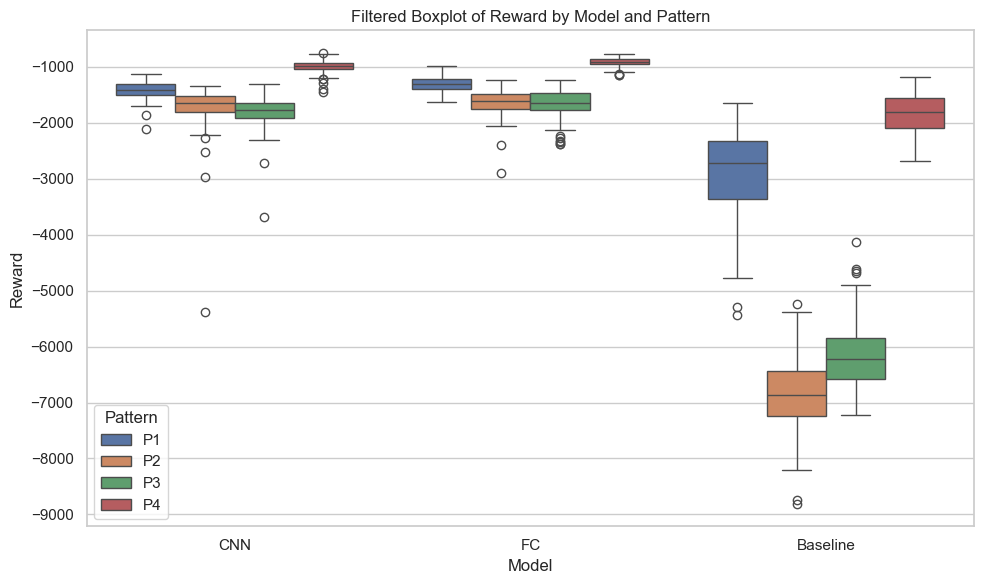

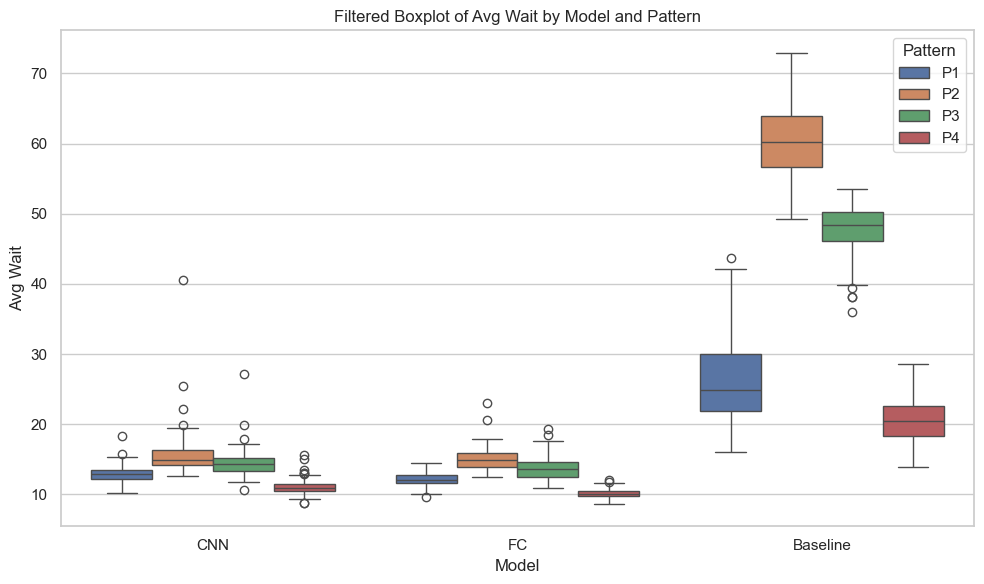

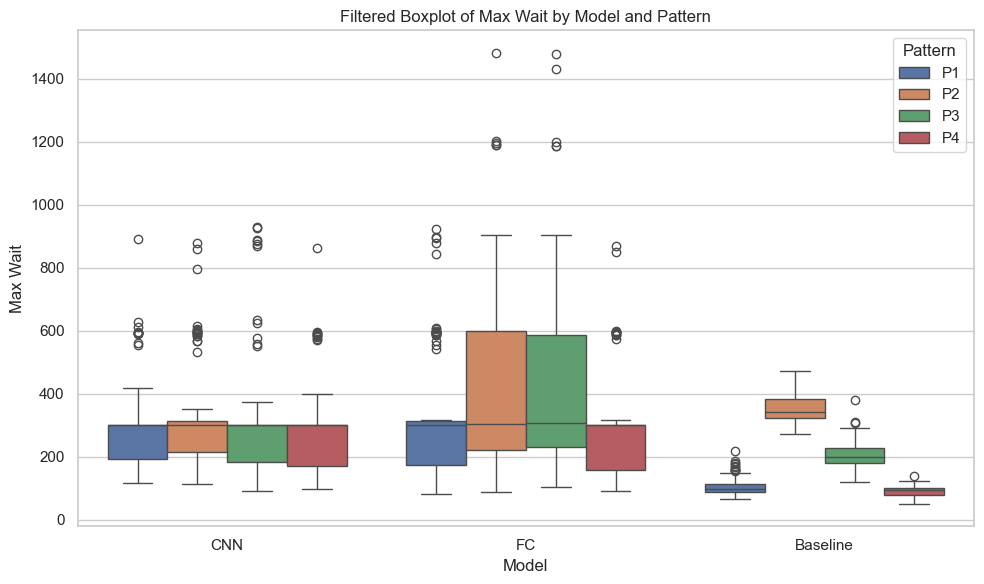

In [99]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


all_results = pd.concat([cnn_results_compiled, fc_results_compiled, baseline_results_compiled], ignore_index=True)

thresholds = {
    "Reward": {"min": -20000, "max": 100000},
    "Avg Wait": {"min": 0, "max": 150},
    "Max Wait": {"min": 0, "max": 1500},
}

def plot_metric_boxplot_filtered(metric_name):
    min_val = thresholds[metric_name]["min"]
    max_val = thresholds[metric_name]["max"]

    filtered_df = all_results[
        (all_results["Metric"] == metric_name) &
        (all_results["Value"] >= min_val) &
        (all_results["Value"] <= max_val)
    ]

    plt.figure(figsize=(10, 6))
    sns.boxplot(
        data=filtered_df,
        x="Model",
        y="Value",
        hue="Pattern"
    )
    plt.title(f"Filtered Boxplot of {metric_name} by Model and Pattern")
    plt.ylabel(metric_name)
    plt.xlabel("Model")
    plt.legend(title="Pattern")
    plt.tight_layout()
    plt.show()

# Plot each metric with filtering
plot_metric_boxplot_filtered("Reward")
plot_metric_boxplot_filtered("Avg Wait")
plot_metric_boxplot_filtered("Max Wait")


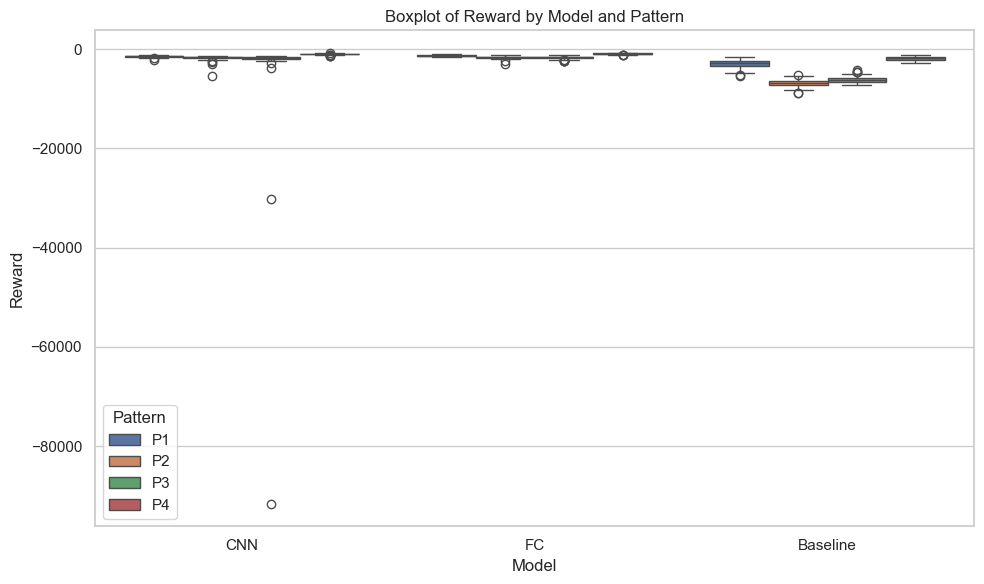

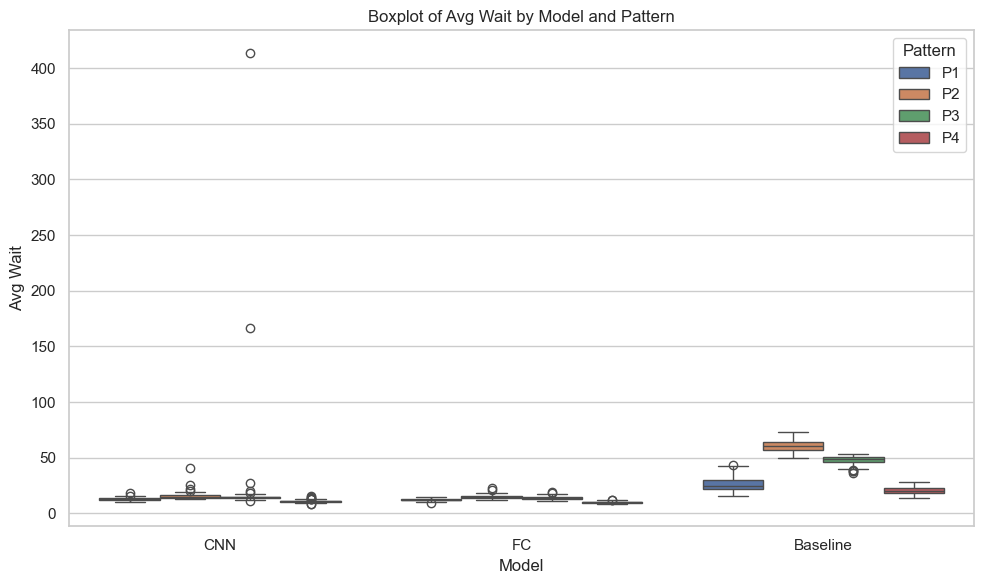

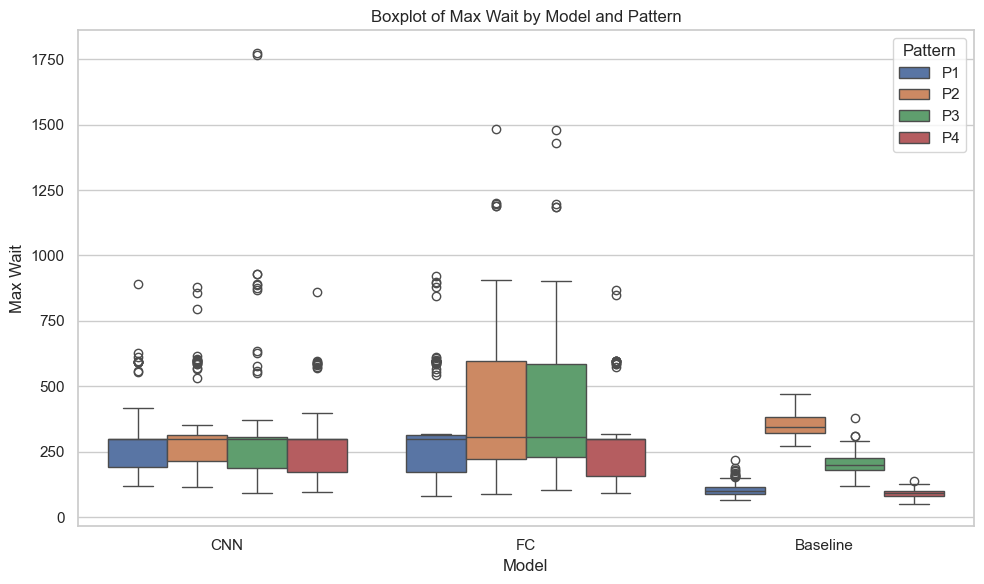

In [100]:
# Function to plot each metric
def plot_metric_boxplot(metric_name):
    plt.figure(figsize=(10, 6))
    sns.boxplot(
        data=all_results[all_results["Metric"] == metric_name],
        x="Model",
        y="Value",
        hue="Pattern"
    )
    plt.title(f"Boxplot of {metric_name} by Model and Pattern")
    plt.ylabel(metric_name)
    plt.xlabel("Model")
    plt.legend(title="Pattern")
    plt.tight_layout()
    plt.show()

# Plot each metric
plot_metric_boxplot("Reward")
plot_metric_boxplot("Avg Wait")
plot_metric_boxplot("Max Wait")


# **Discussion**

<h3 style="margin-bottom:15px"><b>Training Plots and Metrics Analysis</b></h3>
<h5 style="margin-bottom:15px;margin-top:15px">⏳ 📏 Average reward and waiting time per episode:</h5>
<p style="margin-top:15px;margin-bottom:15px">The dense DQN converged relatively quickly (approximately ~25 episodes) and remained stable thereafter at around the -1000 to -2000 reward range and 10-20 seconds wait time range.

The CNN DQN however had slower convergence (approximately ~50 episodes) with less stability over time, and beyond convergence, around the -1000 to -2000 reward and 10-20 second wait time ranges too, but with several seperate spikes - reward decreasing to the -2000 to -4000 range, and wait time going up to the 20-30 second range.

Both cases outperform all baseline model performances across these three training traffic patterns.</p>
<h5 style="margin-bottom:15px;margin-top:15px">❌ 🚗 Maximum wait per vehicle per episode:</h5>
<p style="margin-top:15px;margin-bottom:15px">Both the dense and CNN DQN showed no convergence or clear trend. Strong fluctuations persisted throughout training, with some extremely large values observed. The dense DQN maximum wait times fluctuate mostly in the 100 to 400 second range, however they spike up to 600 a few times, and even one time at 900.

The CNN DQN maximum wait times fluctuate similarly from 100 to 300 ish seconds, reaching into the 400 - 600 seconds range occassionally.

In both cases, although it seems like the baseline performs pretty poor as well with the dotted lines all very high up in the plot, this dotted lines represent the MAXIMUM of the maximum wait times across the episodes. Therefore it can be seen that the baseline does perform better than these models during their training metric calculations regarding maximum waiting times and worst case scenarios.</p>

<h3 style="margin-bottom:15px;"><b>Test and Evaluation Plots and Metrics Analysis</b></h3>
<p style="margin-bottom:15px;margin-top:15px"> Below we can see a plot showing the evaluation results for each model. Each model was run for 100 episodes per traffic pattern. The best and worst performance across all models and patterns are highlighted. </p>

<p align="center">
  <img src="image_8.png" alt="Table of Model Final Evaluation Performances" />
</p>

<h5 style="margin-bottom:15px;margin-top:15px">📏 Average reward per episode:</h5>
<p style="margin-top:15px;margin-bottom:15px">Observing the outputs of cell 99, the dense DQN achieved consistently higher rewards across all patterns compared to the CNN DQN and the baseline models. The CNN DQN performed slightly below the dense DQN but showed more variability in certain patterns. The baseline model performance was significantly worse, particularly for patterns P2 and P3.</p>
<h5 style="margin-bottom:15px;margin-top:15px">⏳ Average waiting time per episode:</h5>
<p style="margin-top:15px;margin-bottom:15px;">The dense DQN and CNN DQN models both maintained low average wait times (average of approximately 10–15s) across patterns, with the CNN DQN slightly higher on average, but not by too much. The baseline model had much higher average waits, especially in P2 (~60s) and P3 (~50s).</p>
<h5 style="margin-bottom:15px;margin-top:15px">❌ 🚗 Maximum wait per vehicle per episode:</h5>
<p style="margin-top:15px;">The dense DQN and CNN DQN both had very large max wait values with wide variability, often exceeding 600 seconds in some patterns. The CNN DQN's max waits were somewhat more consistent across patterns than Dense DQN’s, but still high. The baseline model had lower max waits overall compared to the RL models, likely due to its fixed-timer approach avoiding extreme tail cases.</p>

**Limitations**

### 🚧 1. CNN Model Instability
A key limitation of our project was the poor performance of the CNN model, which theoretically should perform better as it encodes more information relative to queue lane lengths — specifically, it is able to capture movement and location of cars that are not in queue yet. In our evaluations of the model, we observe extreme outliers in performance on the P3 traffic pattern from the CNN model. This, along with the unstable episode rewards during training, indicates that the CNN model had trouble approximating the Q function for the entire action state space.

### ⚖️ 2. Poor Max Waiting Time Performance Relative to Baseline
Previous work on this problem focused on the average values of queue length and waiting time. But by looking at the maximum waiting time, we observe that the Reinforcement Learning agents perform more poorly relative to baseline models. In order to maximise the reward, the agent likely chooses traffic lights that allow the most congested lanes to pass first. In scenarios where there are less congested lanes with only a few vehicles, these cars may be left waiting indefinitely, since prioritizing them does little to improve the total reward. This is more of an ethics problem - should we prioritise the collective (pause) or should we ensure fairness for all. 

<p align="center">
  <img src="image_1.png" alt="Image of lane with less congestion" />
</p>

### 🚦 3. Conflict between optimal queue reduction and road safety
We also have an ethical dilemma between optimal queue reduction and road safety. Currently, traffic light phases have a minimum length of 6 seconds (based on NSW traffic guidelines). We can give the RL agents more fine grained control over traffic lights by reducing the minimum phase length, but this may result in more dangerous road conditions since real life drivers may prefer more stable and predictable signal patterns. 





**Possible future work**

### 1. Improve CNN model
Future work could aim to improve the CNN’s ability to approximate the Q-function more accurately. This can be done by exploring different CNN architectures such as adding more layers, changing filter sizes and stride length. The memory size for experience replay can also be enlarged, allowing the network to see more data points and thus approximate more accurately.

### 2. Incorporation of Waiting Time into Reward 
The omission of waiting time considerations significantly limits the model’s applicability in real-world scenarios. Our RL agents tend to neglect less congested lanes, as servicing them yields minimal gains in the overall reward function. This behavior is undesirable in real-world applications as low-traffic lanes serve real users, and excessive delays can lead to driver frustration, non-compliance with signals, or even safety risks. Real traffic systems must ensure a minimum level of service for all lanes, regardless of volume. 

To handle this, we can incorporate maximum waiting time into the reward function. The choice of the constant $\alpha$, is subjective and dependent on how much maximum waiting time is valued.
$$
R = -(\text{total queue length} + \alpha \cdot \text{max waiting time})
$$

### 3. More control over traffic light duration
When our model selects an action, it currently extends the traffic light by a length of 6 seconds. This means that a green traffic light can only last for periods that are divisible by 6. This limitation stems from the design of our RL agent, and not from real-world traffic regulations. To overcome this, future studies may try building agents which are also capable of choosing how long a traffic light lasts for. This can be done by adding an additional regression head to our DQN, which will then be able to output both the Q values of each potential traffic light phase and also the length of the phase. The conflict between this and the minimum traffic light length duration of 6 seconds in NSW can be easily overcome by using $$ \min(\text{DQN output}, \text{NSW minimum green length}). $$

### 4. Expanding beyond a single intersection
While our project focused on a single intersection, real world traffic systems involve complex interactions between multiple intersections. Expanding the model to larger road networks would allow us to investigate coordination between traffic lights, assess network-wide efficiency, and test whether localized policies scale effectively. It would also enable exploration of strategies like synchronizing consecutive green lights to reduce stop-start driving and improve overall flow. Such a study would require significant amounts of data to replicate real world conditions, and also significant compute for simulation and training.

<p align="center">
  <img src="image_2.png" alt="Image of Sydney traffic network" />
</p>
